## Source/Useful Links

Get the data from: https://www.stratosphereips.org/datasets-ctu13



The CTU-13 is a dataset of botnet traffic that was captured in the CTU University, Czech Republic, in 2011.


## What is IDS (Intrusion Detection System)?

Intrusion Detection Systems (IDS) are precisely present to prevent attacks and infiltration to Networks, which might affect the organization. They monitor network traffic for suspicious activities and issue alert in case of issues.

**Types if IDS:**
> 1. *Signature-based intrusion detection*– In this kind incoming attacks are compared with pre-existing database of known attacks.
> 2. *Anomaly-based intrusion detection*- It uses statistics to form a baseline usage of the networks at different time intervals. They were introduced to detect unknown attacks.

Based on where they discover, they can be classified into:
1. Network intrusion detection (NIDS)
2. Host intrusion detection (HIDS)

## Problem Statement

With the rise of Internet usage, it is very important to protect Networks.  The most common risk to a network’s security is an intrusion such as brute force, denial of service or even an infiltration from within a network. With the changing patterns in network behavior, it is necessary to switch to a dynamic approach to detect and prevent such intrusions.

## Type Of File And Download

The CTU-13 dataset consists in thirteen captures (called scenarios) of different botnet samples. On each scenario we executed a specific malware, which used several protocols and performed different actions. 

Each of the scenarios in the dataset was processed to obtain different files. For privacy issues the complete pcap file containing all the background, normal and botnet data is not available. However, the rest of the files is available. Each scenario contains:

- The pcap file for the botnet capture only. The files have the extension .pcap.
- The bidirectional NetFlow files (generated with Argus) of all the traffic, including the labels. The files have the extension .biargus
- The original executable file.

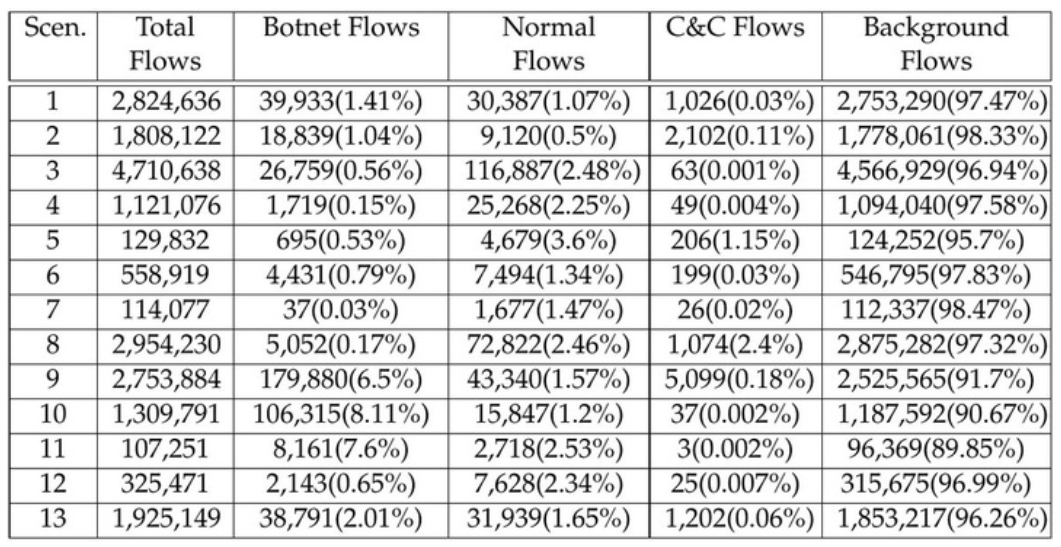

## Features in the Dataset

This dataset has 14 features.
<br>
There are 3 different datatypes:
- Categorical: Proto, SrcAddr, Sport, Dir, DstAddr, Dport, State, , sTos, dTos
- Numerical: Dur, TotPkts, TotBytes, SrcBytes
- Datetime: StartTime

## ML Problem Formulation

*Binary classification of attack category*

The dataset has "label" with 0 and 1 where 0 represents non-attack and 1 represent attack. So with the features available we will try to predict a given datapoint whether it belongs to attack or non-attack category.

## Performance Metrics

1. Accuracy
2. False Alarm Rate

# CTU - 13: Data cleaning and preprocessing

## Importing libraries

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format
import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

## Reading data

In [2]:
# Creating a empty dict, where I will save all parameters required for test data transformation
saved_dict = {}

In [34]:
test_files = ['capture20110811.binetflow','capture20110810.binetflow','capture20110816-2.binetflow','capture20110816.binetflow','capture20110818-2.binetflow','capture20110819.binetflow']

In [59]:
# Reading datasets
dfs = []
pathdir = '../Mine/CTU-13-Dataset'
filenames = os.listdir(pathdir)
train_files = []


for file in filenames:
    if file not in test_file:
        path = os.path.join(pathdir, file)
        train_files.append(file)
        dfs.append(pd.read_csv(path))
all_data = pd.concat(dfs)  # Concat all to a single df


In [60]:
# rename Pandas columns to lower case
all_data.columns= all_data.columns.str.lower()

In [61]:
# Saving useful info, later this will be used to transform raw test data
saved_dict['columns'] = all_data.columns.to_list()

In [62]:
all_data.shape

(14238224, 15)

In [63]:
all_data.head()

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label
0,2011/08/16 14:23:17.316620,0.983988,tcp,147.32.3.51,4519,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
1,2011/08/16 14:25:13.585599,0.909895,tcp,147.32.84.59,61591,->,199.59.149.200,443,SR_A,0.0,0.0,3,204,138,flow=Background-Established-cmpgw-CVUT
2,2011/08/16 14:26:27.614070,3.067423,tcp,217.129.160.86,2228,->,147.32.84.229,13363,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
3,2011/08/16 14:26:29.245037,2.856905,tcp,217.129.160.86,2231,->,147.32.84.229,443,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
4,2011/08/16 14:26:30.868242,2.985940,tcp,217.129.160.86,2234,->,147.32.84.229,80,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established


## Data cleaning and pre-processing

In [64]:
# Splitting data into train and test
# All the operation like cleaning, EDA and FE will be done on train data only

train, test = train_test_split(all_data, test_size=0.3, random_state=42)

In [65]:
# Deleting the concatenated dataframe, as we don't need that anymore
del all_data

In [66]:
print(train.shape,'\n',test.shape)

(9966756, 15) 
 (4271468, 15)


In [67]:
# checking for null values
train.isnull().sum()

starttime         0
dur               0
proto             0
srcaddr           0
sport        128107
dir               0
dstaddr           0
dport        122767
state           880
stos         138179
dtos         816972
totpkts           0
totbytes          0
srcbytes          0
label             0
dtype: int64

### Filling Null values

In [68]:
train['state'].value_counts()

CON            7039709
FSPA_FSPA      1085541
INT             302315
S_              258791
S_RA            250410
                ...   
FSA_FSRPA            1
SRPAC_FSRPA          1
FSRA_SRPA            1
FSPAC_FA             1
_S                   1
Name: state, Length: 408, dtype: int64

In [69]:
# We replace Null value to Con 
train['state'] = train.state.fillna(value='CON')

In [70]:
# fill nan port forward 
train['sport'] = train.sport.fillna(method='pad')
train['dport'] = train.dport.fillna(method='pad')

In [71]:
train.stos.value_counts()

0.0      9815721
192.0       5135
3.0         4863
2.0         1518
1.0         1340
Name: stos, dtype: int64

In [74]:
train.dtos.value_counts()

0.0    9148369
3.0        741
2.0        624
1.0         50
Name: dtos, dtype: int64

In [75]:
train['stos'] = train.stos.fillna(value=0.0)
train['dtos'] = train.dtos.fillna(value=0.0)

In [76]:
# There are no Null values in the train data anymore
train.isnull().sum().sum()

0

In [77]:
train = train.drop(train[train.stos == 192.0].index)

In [78]:
train.shape

(9950992, 15)

## Information about dataset

In [79]:
# Getting name of all the columns
train.columns

Index(['starttime', 'dur', 'proto', 'srcaddr', 'sport', 'dir', 'dstaddr',
       'dport', 'state', 'stos', 'dtos', 'totpkts', 'totbytes', 'srcbytes',
       'label'],
      dtype='object')

### Class distribution

In [80]:
def convertlabel(sample):
    if "Botnet" in sample: return 1
    else: return 0

In [81]:
train['target'] = train['label'].apply(convertlabel)

In [82]:
test['target'] = test['label'].apply(convertlabel)

In [83]:
train_0, train_1 = train['target'].value_counts()[0] / len(train.index), train['target'].value_counts()[1] / len(train.index)
test_0, test_1 = test['target'].value_counts()[0] / len(test.index), test['target'].value_counts()[1] / len(test.index)

print("In Train: there are {} % of class 0 and {} % of class 1".format(train_0, train_1))
print("In Test: there are {} % of class 0 and {} % of class 1".format(test_0, test_1))

In Train: there are 0.9741811670635451 % of class 0 and 0.02581883293645498 % of class 1
In Test: there are 0.9741266936800183 % of class 0 and 0.025873306319981797 % of class 1


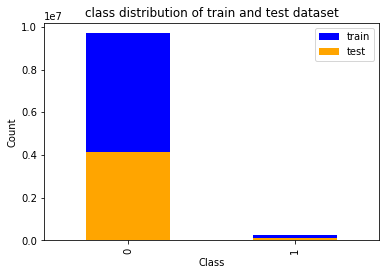

In [84]:
# Plotting target label distribution
plt.figure()
plt.title("class distribution of train and test dataset")
train['target'].value_counts().plot(kind="bar", color='b', label="train")
test['target'].value_counts().plot(kind="bar", color='orange', label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

Both train and test datasets are highly imbalanced.<br>
Percentage of points belongs to class 1 (attack) is very little (only 2 %) in both of them.


### Datatype information of the Features

In [85]:
# Check if any null value present in datasets
train.isnull().sum().sum(), test.isnull().sum().sum()  # No Null in train and test data is still raw

(0, 518168)

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950992 entries, 446771 to 234218
Data columns (total 16 columns):
 #   Column     Dtype  
---  ------     -----  
 0   starttime  object 
 1   dur        float64
 2   proto      object 
 3   srcaddr    object 
 4   sport      object 
 5   dir        object 
 6   dstaddr    object 
 7   dport      object 
 8   state      object 
 9   stos       float64
 10  dtos       float64
 11  totpkts    int64  
 12  totbytes   int64  
 13  srcbytes   int64  
 14  label      object 
 15  target     int64  
dtypes: float64(3), int64(4), object(9)
memory usage: 1.3+ GB


In [87]:
# All the datatypes in our dataset
train.dtypes.value_counts()

object     9
int64      4
float64    3
dtype: int64

In [88]:
# Categorical feature names
train.select_dtypes(exclude=np.number).columns

Index(['starttime', 'proto', 'srcaddr', 'sport', 'dir', 'dstaddr', 'dport',
       'state', 'label'],
      dtype='object')

In [89]:
# Numeric features names
train.select_dtypes(include=np.number).columns

Index(['dur', 'stos', 'dtos', 'totpkts', 'totbytes', 'srcbytes', 'target'], dtype='object')

In [90]:
# Convert starttime to datetime dtypes
train['starttime'] = pd.to_datetime(train['starttime'])
test['starttime'] = pd.to_datetime(test['starttime'])

**Observations:**
1. In this dataset there are mainly 2 types of data types present
    - numerical
    - categorical

2. Categorical columns: proto', 'srcaddr', 'dir', 'dstaddr', 'state', 'stos', 'dtos'


3. Numerical columns : 'dur', 'totpkts', 'totbytes', 'srcbytes', 'sport', 'dport'

4. Target columns: 'target', 'label'

### Fixing values of the columns

## Saving files to disk

In [93]:
train.shape, test.shape

((9950992, 16), (4271468, 16))

In [94]:
train.to_csv('./train_alldata_EDA.csv')
test.to_csv('./test_alldata_EDA.csv')

In [95]:
saved_dict

{'columns': ['starttime',
  'dur',
  'proto',
  'srcaddr',
  'sport',
  'dir',
  'dstaddr',
  'dport',
  'state',
  'stos',
  'dtos',
  'totpkts',
  'totbytes',
  'srcbytes',
  'label']}

In [96]:
pickle.dump(saved_dict, open('./final_ipynb', 'wb'))